In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
import pathlib
data_dir = '/content/drive/MyDrive/archive/flowers'

data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4323


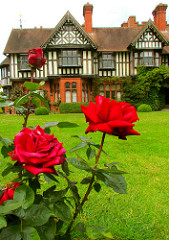

In [12]:
roses = list(data_dir.glob("rose/*"))
PIL.Image.open(str(roses[0]))

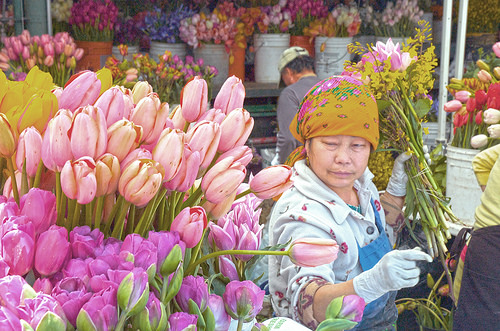

In [13]:
tulips = list(data_dir.glob('tulip/*'))
PIL.Image.open(str(tulips[0]))

In [14]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.
Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


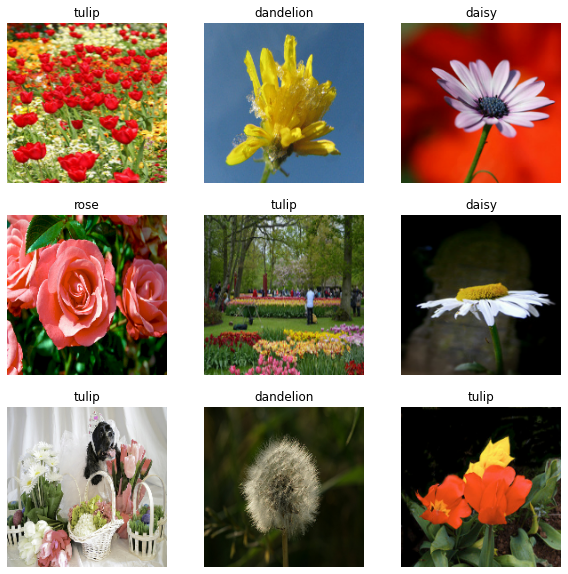

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [19]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [35]:
epochs = 11
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[reduce_lr,early_stop]
)

Epoch 1/11
109/109 [==============================] - 122s 1s/step - loss: 0.1188 - accuracy: 0.9610 - val_loss: 0.2191 - val_accuracy: 0.9363
Epoch 2/11
109/109 [==============================] - 122s 1s/step - loss: 0.1211 - accuracy: 0.9595 - val_loss: 0.2310 - val_accuracy: 0.9329
Epoch 3/11
109/109 [==============================] - 122s 1s/step - loss: 0.1221 - accuracy: 0.9615 - val_loss: 0.2330 - val_accuracy: 0.9317
Epoch 4/11
109/109 [==============================] - 122s 1s/step - loss: 0.1168 - accuracy: 0.9607 - val_loss: 0.2347 - val_accuracy: 0.9340
Epoch 5/11
109/109 [==============================] - 122s 1s/step - loss: 0.0982 - accuracy: 0.9673 - val_loss: 0.2427 - val_accuracy: 0.9271
Epoch 6/11
109/109 [==============================] - 122s 1s/step - loss: 0.1088 - accuracy: 0.9592 - val_loss: 0.2410 - val_accuracy: 0.9282
Epoch 7/11
109/109 [==============================] - 123s 1s/step - loss: 0.1076 - accuracy: 0.9621 - val_loss: 0.2536 - val_accuracy: 0.9248

In [40]:
def show_history(history): 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

In [39]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflower with a 100.00 percent confidence.
